In [1]:
# ===================================================
# Product Usage & Monetization/Pricing Dashboard
# ===================================================

# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import scipy.stats as stats

In [2]:
# --------------------------
# Load data
# --------------------------
data_dir = "./mpud/mobile_phone_use/data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]

In [3]:
# --------------------------
# Clean data
# --------------------------

# Sample first 120 participants, and drop non-critical features
dfs = []

for f in files[:120]:
    df = pd.read_csv(f, dtype=object)
    df = df.iloc[:, 0:10]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print(f"Dataset loaded: {data.shape}")

Dataset loaded: (10682803, 10)


In [4]:
# Timestamp to datetime
data['ts'] = pd.to_datetime(data['ts'])

# Filter for only relevant events
sensors = ['App', 'Notif', 'Screen']
data_s = data[data['sensor_id'].isin(sensors)]

# Drop missing values in critical columns
data_s = data_s.dropna(subset=['ts','uuid','sensor_id'])

data_s.shape

(2298739, 10)

In [5]:
# --------------------------
# EDA & Usage Metrics
# --------------------------

# Daily screen-on time (assuming screentime of 30mins for each hour of day the screen turned on)
daily_screen = data_s[data_s['sensor_id']=='Screen']
daily_screen = daily_screen.groupby([daily_screen['uuid'], daily_screen['ts'].dt.date])['HourOfDay'].nunique().reset_index()
daily_screen['HourOfDay'] = daily_screen['HourOfDay'] * 0.5
daily_screen.rename(columns={'HourOfDay':'screen_on_time_hours','ts':'date'}, inplace=True)

print(daily_screen.shape, daily_screen.head())


(3095, 3)       uuid        date  screen_on_time_hours
0  u072142  2016-06-19                   3.0
1  u072142  2016-06-20                   6.5
2  u072142  2016-06-21                   7.5
3  u072142  2016-06-22                   7.0
4  u072142  2016-06-23                   9.0


In [6]:
# Daily number of app sessions
daily_sessions = data_s[data_s['sensor_id']=='App']
daily_sessions = daily_sessions.groupby([daily_sessions['uuid'], daily_sessions['ts'].dt.date]).size().reset_index()
daily_sessions.rename(columns={0:'num_app_sessions','ts':'date'}, inplace=True)

print(daily_sessions.shape, daily_sessions.head())

(2908, 3)       uuid        date  num_app_sessions
0  u072142  2016-06-19                94
1  u072142  2016-06-20                48
2  u072142  2016-06-21                76
3  u072142  2016-06-22                84
4  u072142  2016-06-23                86


In [7]:
# Daily notifications
daily_notifs = data_s[data_s['sensor_id']=='Notif']
daily_notifs = daily_notifs.groupby([daily_notifs['uuid'], daily_notifs['ts'].dt.date]).size().reset_index()
daily_notifs.rename(columns={0:'num_notifications','ts':'date'}, inplace=True)

print(daily_notifs.head())

      uuid        date  num_notifications
0  u072142  2016-06-19                206
1  u072142  2016-06-20                101
2  u072142  2016-06-21                174
3  u072142  2016-06-22                144
4  u072142  2016-06-23                129


In [8]:
# Merge daily metrics
daily = daily_screen.merge(daily_sessions, on=['uuid','date'], how='outer')
daily = daily.merge(daily_notifs, on=['uuid','date'], how='outer')
daily = daily.fillna(0)

daily.to_csv("user_daily_metrics.csv", index=False)

print(daily.shape, daily.head())

(3100, 5)       uuid        date  screen_on_time_hours  num_app_sessions  \
0  u072142  2016-06-19                   3.0              94.0   
1  u072142  2016-06-20                   6.5              48.0   
2  u072142  2016-06-21                   7.5              76.0   
3  u072142  2016-06-22                   7.0              84.0   
4  u072142  2016-06-23                   9.0              86.0   

   num_notifications  
0              206.0  
1              101.0  
2              174.0  
3              144.0  
4              129.0  


In [9]:
# Aggregate per user
user_avg_metrics = daily.groupby('uuid').agg({
    'screen_on_time_hours':'mean',
    'num_app_sessions':'mean',
    'num_notifications':'mean'
}).reset_index()
user_avg_metrics.rename(columns={
    'screen_on_time_hours':'avg_daily_screen_time',
    'num_app_sessions':'avg_daily_sessions',
    'num_notifications':'avg_daily_notifications'
}, inplace=True)

print(user_avg_metrics.shape, user_avg_metrics.head())

(120, 4)       uuid  avg_daily_screen_time  avg_daily_sessions  avg_daily_notifications
0  u072142               6.934783           66.652174                86.956522
1  u0cba7d               6.659091          116.954545               128.227273
2  u11abb4               8.424242          242.787879               293.030303
3  u11cef8               6.642857            2.071429                 1.714286
4  u11cf22               8.843750          299.406250               154.906250


Text(0.5, 1.0, 'User Avg Daily App Sessions / Screen Time')

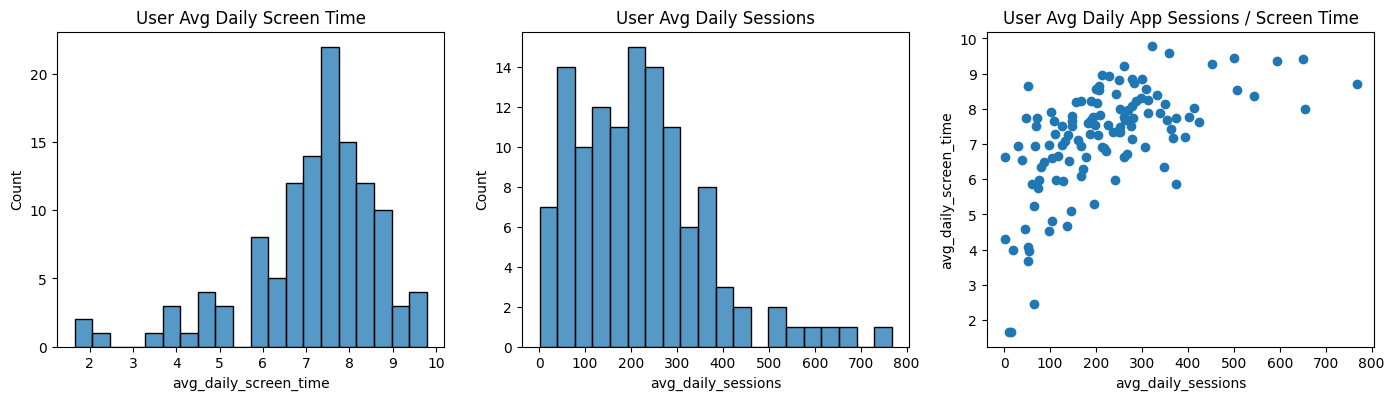

In [10]:
# --------------------------
# Handle Outliers
# --------------------------

# Plot critical features
plt.figure(figsize=(17, 9))

plt.subplot(2, 3, 1)
sns.histplot(user_avg_metrics['avg_daily_screen_time'], bins=20)
plt.title("User Avg Daily Screen Time")


plt.subplot(2,3,2)
sns.histplot(user_avg_metrics['avg_daily_sessions'], bins=20)
plt.title("User Avg Daily Sessions")

plt.subplot(2, 3, 3)
plt.scatter(user_avg_metrics['avg_daily_sessions'], user_avg_metrics['avg_daily_screen_time'])
plt.xlabel('avg_daily_sessions')
plt.ylabel('avg_daily_screen_time')
plt.title("User Avg Daily App Sessions / Screen Time")

In [11]:
# Detect and remove outliers
q1 = user_avg_metrics['avg_daily_screen_time'].quantile(0.25)
q3 = user_avg_metrics['avg_daily_screen_time'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr
print(upper_limit, lower_limit)

user_avg_metrics = user_avg_metrics[(user_avg_metrics['avg_daily_screen_time'] >= lower_limit) & (user_avg_metrics['avg_daily_screen_time'] <= upper_limit)]

10.393594457013574 4.360675904977377


In [12]:
q1 = user_avg_metrics['avg_daily_sessions'].quantile(0.25)
q3 = user_avg_metrics['avg_daily_sessions'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr
print(upper_limit, lower_limit)

user_avg_metrics = user_avg_metrics[(user_avg_metrics['avg_daily_sessions'] >= lower_limit) & (user_avg_metrics['avg_daily_sessions'] <= upper_limit)]

543.3299932065219 -108.7458220108696


Text(0.5, 1.0, 'User Avg Daily App Sessions / Screen Time')

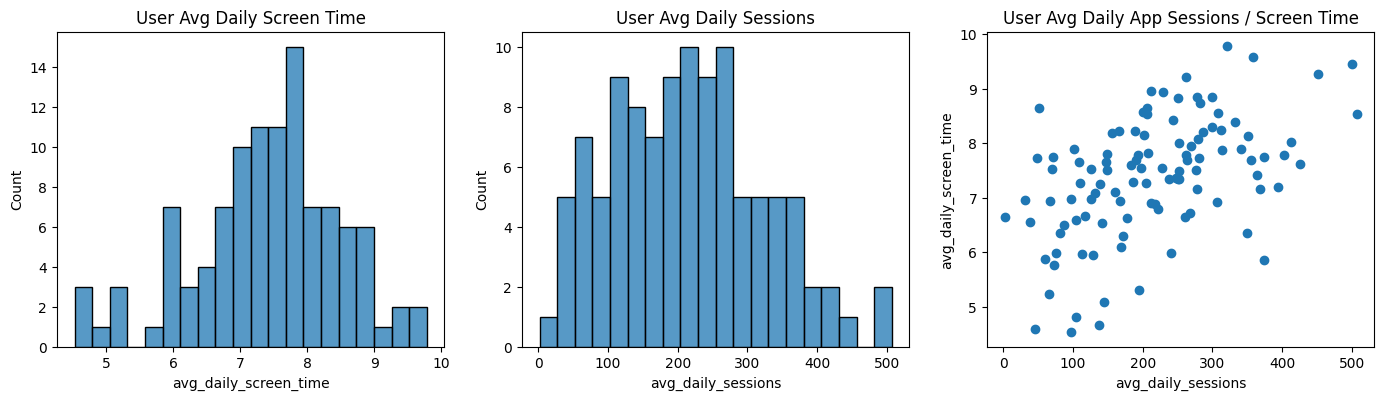

In [13]:
# Plot updated critical features
plt.figure(figsize=(17, 9))

plt.subplot(2, 3, 1)
sns.histplot(user_avg_metrics['avg_daily_screen_time'], bins=20)
plt.title("User Avg Daily Screen Time")


plt.subplot(2,3,2)
sns.histplot(user_avg_metrics['avg_daily_sessions'], bins=20)
plt.title("User Avg Daily Sessions")

plt.subplot(2, 3, 3)
plt.scatter(user_avg_metrics['avg_daily_sessions'], user_avg_metrics['avg_daily_screen_time'])
plt.xlabel('avg_daily_sessions')
plt.ylabel('avg_daily_screen_time')
plt.title("User Avg Daily App Sessions / Screen Time")

In [14]:
# --------------------------
# Create Usage Clusters With KMeans
# --------------------------

# Standardize metrics and calculate usage score
scaler = MinMaxScaler()
X = scaler.fit_transform(user_avg_metrics[['avg_daily_screen_time','avg_daily_sessions']])
user_avg_metrics['usage_score'] = X.mean(axis=1)

print(user_avg_metrics['usage_score'])

0      0.292877
1      0.316499
2      0.609027
3      0.201132
4      0.705016
         ...   
114    0.246829
115    0.402827
117    0.260433
118    0.374882
119    0.185124
Name: usage_score, Length: 107, dtype: float64


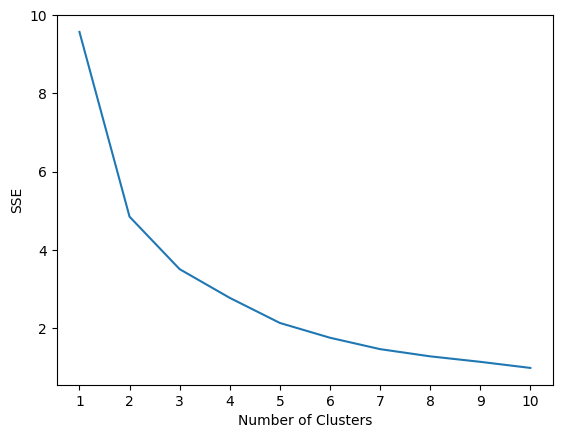

In [15]:
# Find the optimal number of clusters
kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 10,
    'random_state': 1,
}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [16]:
# Perform KMeans Clustering With Optimal K
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=1)
kmeans.fit(X)
user_avg_metrics['cluster'] = kmeans.labels_

print(user_avg_metrics.head())

      uuid  avg_daily_screen_time  avg_daily_sessions  \
0  u072142               6.934783           66.652174   
1  u0cba7d               6.659091          116.954545   
2  u11abb4               8.424242          242.787879   
3  u11cef8               6.642857            2.071429   
4  u11cf22               8.843750          299.406250   

   avg_daily_notifications  usage_score  cluster  
0                86.956522     0.292877        0  
1               128.227273     0.316499        0  
2               293.030303     0.609027        2  
3                 1.714286     0.201132        0  
4               154.906250     0.705016        2  


<Axes: xlabel='cluster', ylabel='avg_daily_screen_time'>

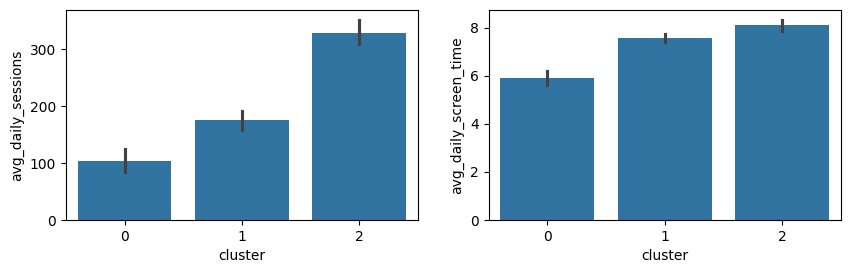

In [17]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.barplot(x='cluster', y='avg_daily_sessions', data=user_avg_metrics)

plt.subplot(2, 2, 2)
sns.barplot(x='cluster', y='avg_daily_screen_time', data=user_avg_metrics)

In [18]:
# Assign tiers (Light, Medium, Heavy) Per Cluster
user_avg_metrics['tier'] = user_avg_metrics['cluster'].map({0:'Light', 1:'Medium', 2:'Heavy'})

# Assign prices
price_map = {'Light':5, 'Medium':15, 'Heavy':30}
user_avg_metrics['assigned_price_usd'] = user_avg_metrics['tier'].map(price_map)

user_avg_metrics.to_csv("user_avg_metrics.csv", index=False)
print(user_avg_metrics.head())

      uuid  avg_daily_screen_time  avg_daily_sessions  \
0  u072142               6.934783           66.652174   
1  u0cba7d               6.659091          116.954545   
2  u11abb4               8.424242          242.787879   
3  u11cef8               6.642857            2.071429   
4  u11cf22               8.843750          299.406250   

   avg_daily_notifications  usage_score  cluster   tier  assigned_price_usd  
0                86.956522     0.292877        0  Light                   5  
1               128.227273     0.316499        0  Light                   5  
2               293.030303     0.609027        2  Heavy                  30  
3                 1.714286     0.201132        0  Light                   5  
4               154.906250     0.705016        2  Heavy                  30  


In [19]:
# --------------------------
# Prepare Aggregated Dataset for Tableau
# --------------------------

# Tier summary
tier_summary = user_avg_metrics.groupby('tier', observed=False).agg({
    'avg_daily_screen_time':'mean',
    'avg_daily_sessions':'mean',
    'avg_daily_notifications':'mean',
    'assigned_price_usd':'first',
    'uuid':'count'
}).rename(columns={'uuid':'num_users'}).reset_index()

print(len(tier_summary))

3


In [20]:
# Daily time-series metrics by tier
daily2 = daily.merge(user_avg_metrics[['uuid','tier']], on='uuid', how='left')
daily_ts = daily2.groupby(['date','tier'], observed=False).agg({
    'screen_on_time_hours':'mean',
    'num_app_sessions':'mean',
    'num_notifications':'mean'
}).reset_index()

daily_ts.to_csv("daily_timeseries_by_tier.csv", index=False)
print(len(daily_ts))

157


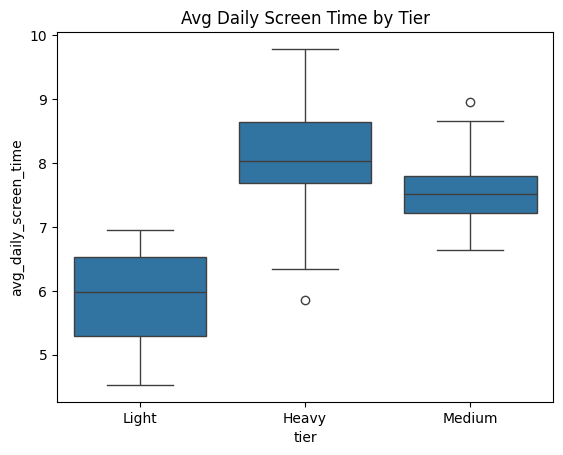

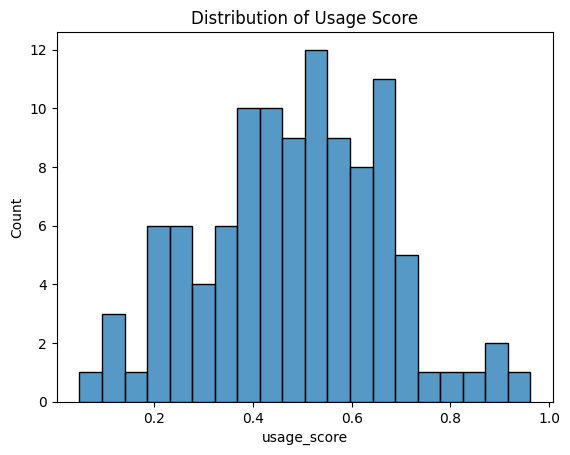

In [21]:
# --------------------------
# Python Visualization
# --------------------------
sns.boxplot(x='tier', y='avg_daily_screen_time', data=user_avg_metrics)
plt.title("Avg Daily Screen Time by Tier")
plt.show()

sns.histplot(user_avg_metrics['usage_score'], bins=20)
plt.title("Distribution of Usage Score")
plt.show()